In [1]:
import impaintingLib as imp
import torch 
import matplotlib.pyplot as plt

In [2]:
def plot(image):
    image = torch.clip(image,0,1)
    plt.figure(figsize=(4,3))
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')

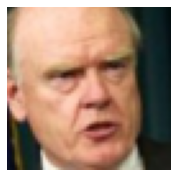

In [3]:
trainloader, testloader = imp.data.getFaces(shuffle=False,doNormalize=False)
imgs, _ = next(iter(testloader))

img = imgs[0]
plot(img)

torch.Size([3, 64, 64])
torch.Size([1, 64, 64])
tensor([[255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        ...,
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.],
        [255., 255., 255.,  ..., 255., 255., 255.]])


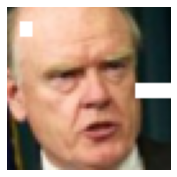

In [4]:
c, h, w = img.shape

w11 = 5
h11 = 6
        
w22 = 50
h22 = 30

print(img.shape)
        
# cutouts = torch.empty((1, h, w), dtype=img.dtype, device=img.device)
cutouts = torch.full((1,h,w),255, dtype=img.dtype, device=img.device)
cutouts[:, h11:h11 + h11, w11:w11 + w11] = 0
cutouts[:, h22:h22 + h11, w22:w22 + w22] = 0

print(cutouts.shape)

res = torch.cat((img,cutouts),0)
plot(res)

print(res[-1])

In [5]:
imgs, _ = next(iter(testloader))

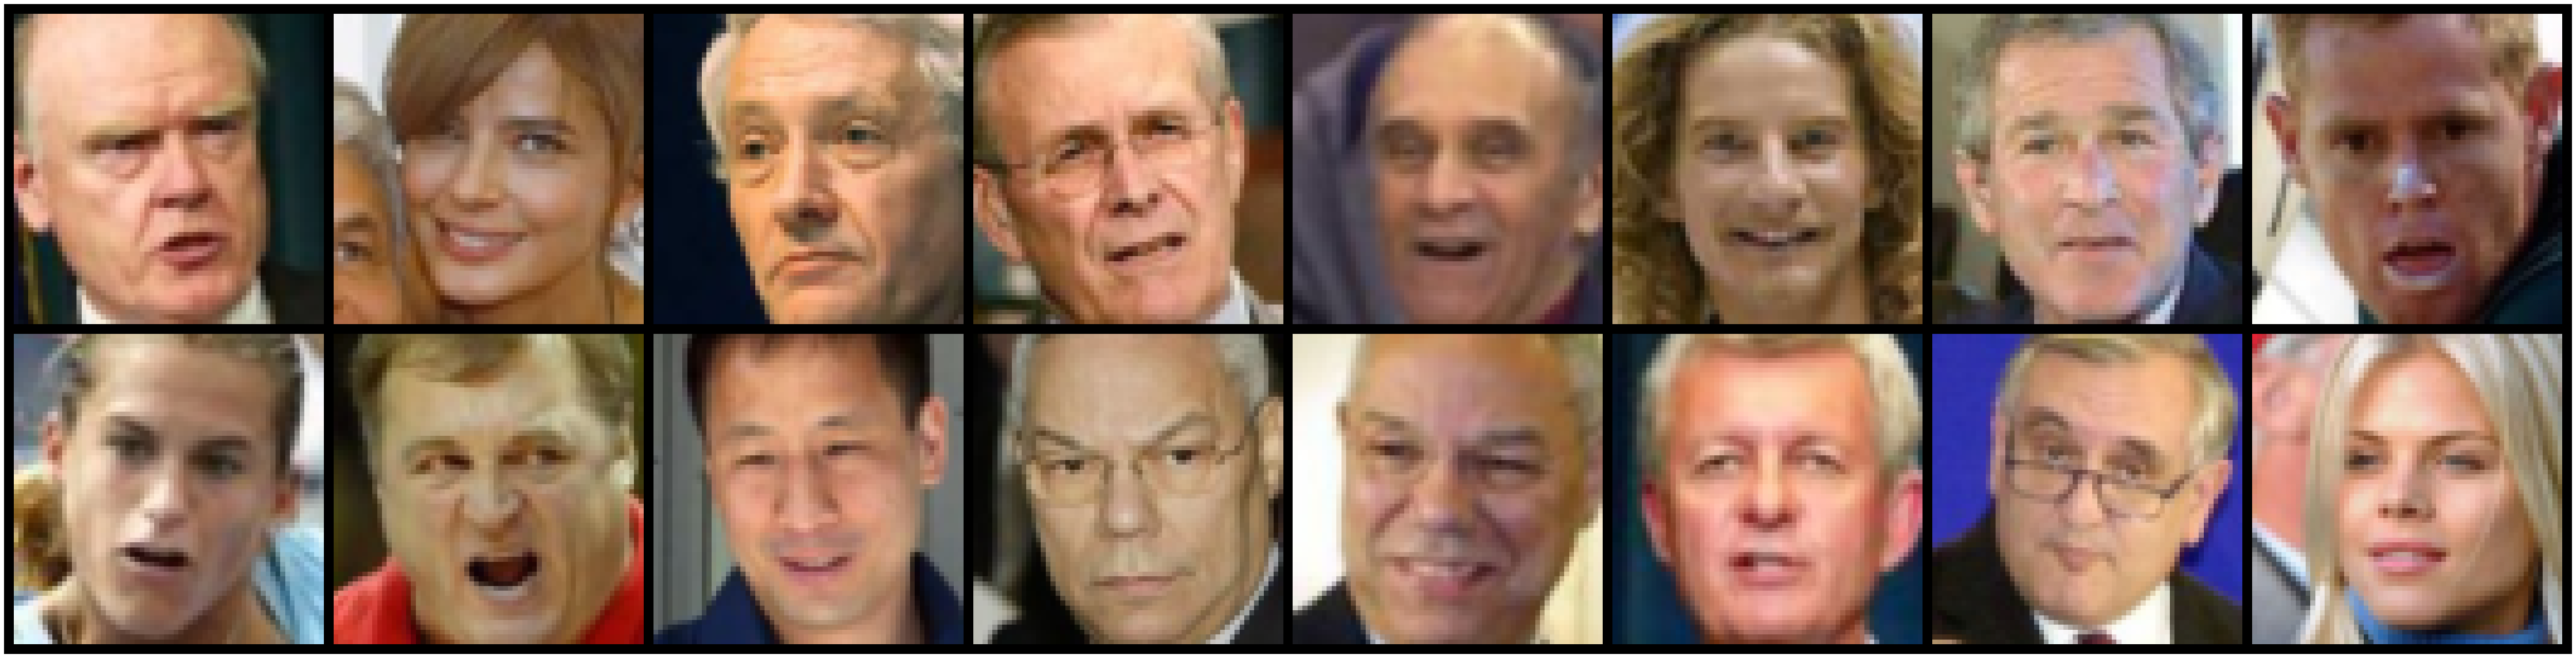

In [6]:
visu = imp.utils.Visu()
visu.plot_img(imgs)

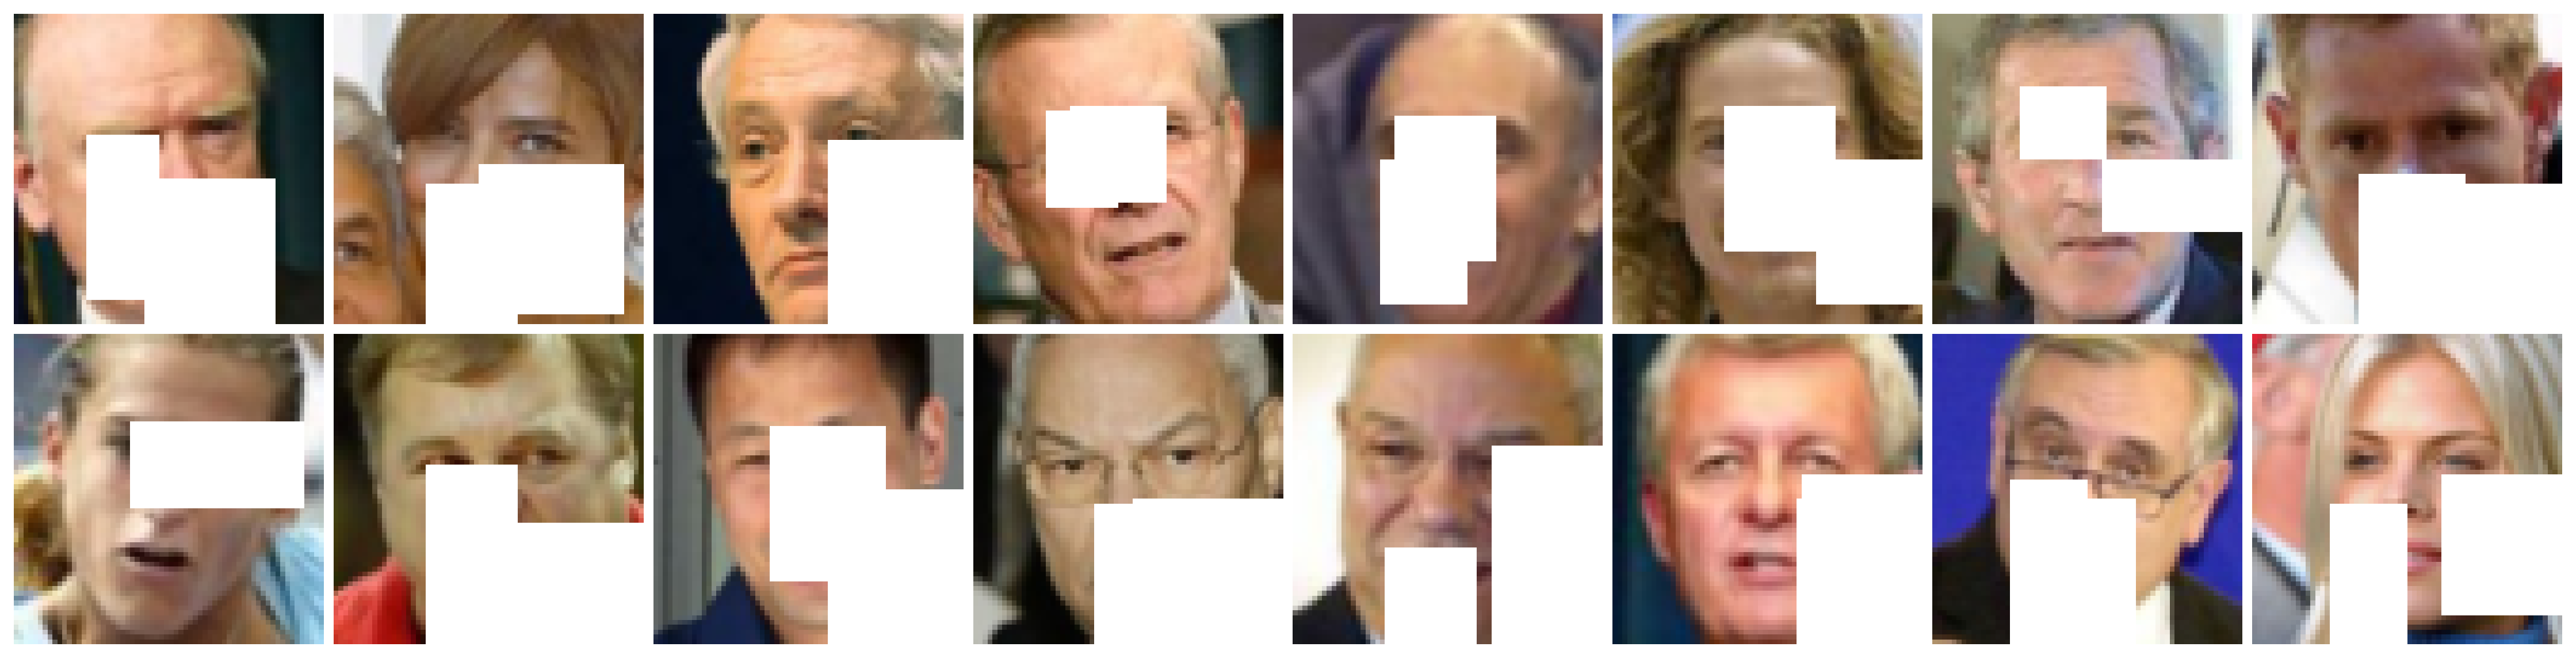

In [7]:
alter = imp.mask.Alter()
imgs = alter.squareMask(imgs)
visu.plot_img(imgs)

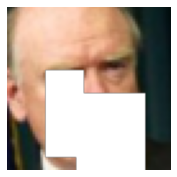

In [8]:
img = imgs[0]
plot(img)

In [9]:
import impaintingLib as imp

In [10]:
# imp.loss.perceptualAE(1,2)